In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from numpy import genfromtxt

Using Theano backend.
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [86]:
fname = '/Users/ckruse/Documents/GitHub/OldFaithful/Old_Faithful_Logger.tsv'
temp = genfromtxt(fname, delimiter = '	')
time = temp[1:-1,0]
temp = temp[1:-1,1]
np.shape(temp)

(282084,)

In [87]:
#Normalize deltas between -1 and 1

print(np.max(temp))

temp = temp/np.max(temp)*2 - 1
print(np.max(temp))

58.153888888889
1.0


In [88]:
def create_dataset(dataset, labels, look_back):
	dataX, dataY = [], []
	for i in range(0,len(dataset)-look_back-1,1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(labels[i + look_back])
	return np.array(dataX), np.array(dataY)

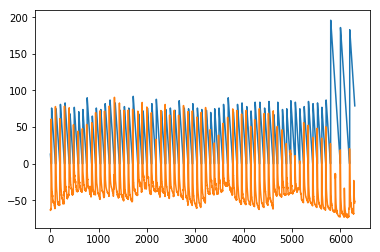

196


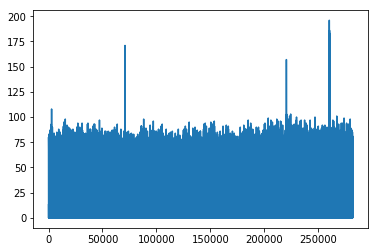

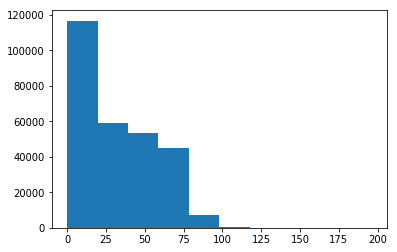

1.0
1.0


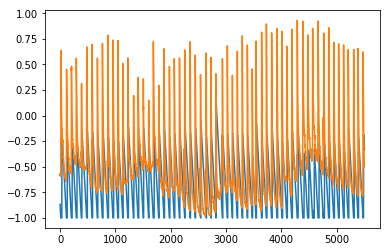

In [116]:
timing = []
i = 0
start = 0
for measurement in range(0, len(temp)):
    
    if temp[measurement] < -0.10:
        timing.append(i)
        i += 1

    else:
        i = 0
        timing.append(i)
        end = measurement
        timing[start:end] = np.max(timing[start:end])-timing[start:end]
        start = measurement

np.argmax(timing)
#plt.figure(figsize=(20,14))
plt.plot(timing[np.argmax(timing)-5800:np.argmax(timing)+500])
plt.plot(100*temp[np.argmax(timing)-5800:np.argmax(timing)+500])
plt.show()

print(np.max(timing))

#plt.figure(figsize=(20,14))
plt.plot(timing[:])
plt.show()

plt.hist(timing)
plt.show()
plt.figure(figsize=(6,4))


timing = np.divide(timing,np.max(timing))*2 - 1
print(np.max(timing))
print(np.max(temp))


plt.plot(timing[0:5500])
plt.plot(temp[0:5500])
plt.show()

(253774, 100)


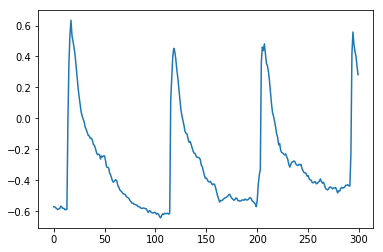

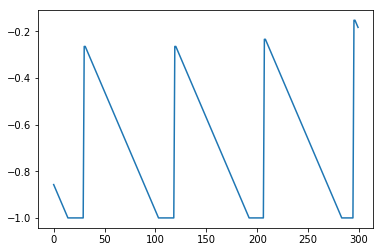

(253774, 100, 1)
(253774,)


In [106]:
val = 0.1
seq_len = 100

X, Y = create_dataset(temp[0:int(len(temp)-val*len(temp))], timing[0:int(len(timing)-val*len(timing))], seq_len)
X_val, Y_val = create_dataset(temp[int(len(temp)-val*len(temp)):-1], timing[int(len(timing)-val*len(timing)):-1], seq_len)

print(X.shape)
plt.plot(X[0:300,0])
plt.show()
plt.plot(Y[0:300])
plt.show()
X = X.reshape(X.shape[0], X.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
Y = Y.reshape(Y.shape[0])

print(X.shape)
print(Y.shape)


In [107]:
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten

model = Sequential()

model.add(Conv1D(filters=4, kernel_size=16, activation='relu', input_shape=(np.shape(X)[1],np.shape(X)[2]), strides=4))
model.add(Conv1D(filters=8, kernel_size=16, activation='relu', strides=4))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mae'])



Train on 253774 samples, validate on 28107 samples
Epoch 1/10
253774/253774 [==============================] - 5s - loss: 0.0299 - mean_absolute_error: 0.1092 - val_loss: 0.0330 - val_mean_absolute_error: 0.0963
Epoch 2/10
253774/253774 [==============================] - 5s - loss: 0.0188 - mean_absolute_error: 0.0831 - val_loss: 0.0344 - val_mean_absolute_error: 0.0918
Epoch 3/10
253774/253774 [==============================] - 5s - loss: 0.0168 - mean_absolute_error: 0.0771 - val_loss: 0.0308 - val_mean_absolute_error: 0.0858
Epoch 4/10
253774/253774 [==============================] - 5s - loss: 0.0162 - mean_absolute_error: 0.0751 - val_loss: 0.0313 - val_mean_absolute_error: 0.0855
Epoch 5/10
253774/253774 [==============================] - 5s - loss: 0.0159 - mean_absolute_error: 0.0746 - val_loss: 0.0310 - val_mean_absolute_error: 0.0841
Epoch 6/10
253774/253774 [==============================] - 5s - loss: 0.0157 - mean_absolute_error: 0.0740 - val_loss: 0.0308 - val_mean_absolu

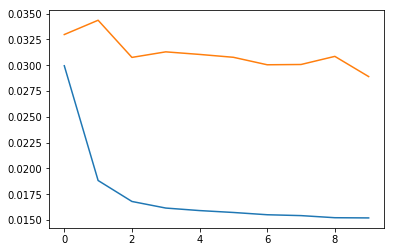

In [108]:
from keras.models import load_model

epochs = 10

#model = load_model('/Users/ckruse/Documents/python/oldFaithfulTemp.h5')
history = model.fit(X,
                    Y,
                    epochs=epochs,
                    validation_data = [X_val,Y_val],
                    verbose=1,
                    batch_size=256,
                    shuffle=True)

model.save('/Users/ckruse/Documents/python/oldFaithfulTemp.h5')
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.show()

#score = model.evaluate(data_stack, label_stack, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])
#model.save('/Users/ckruse/Documents/python/soccer/model.h5')

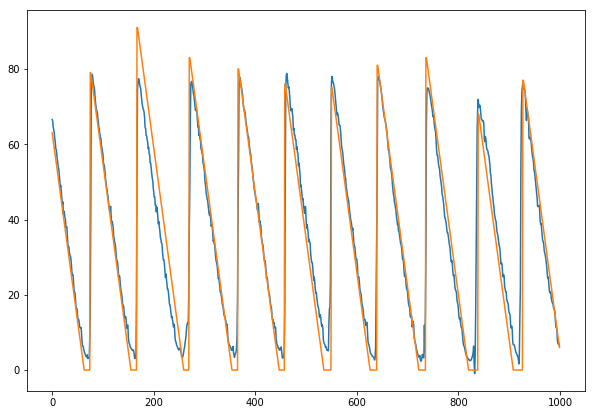

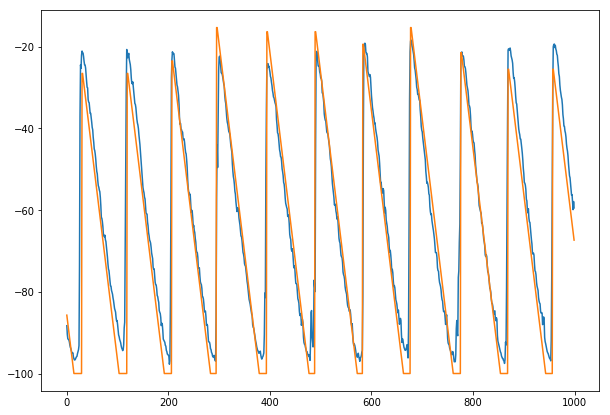

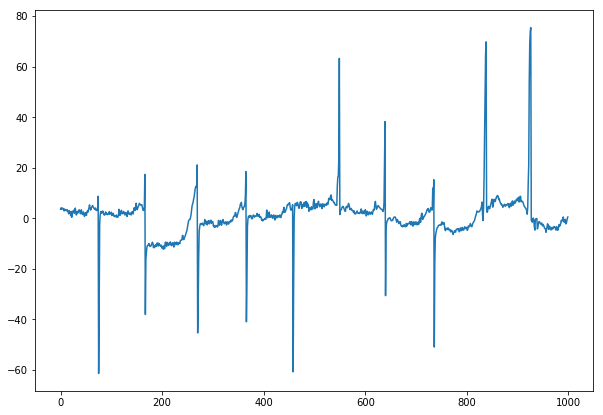

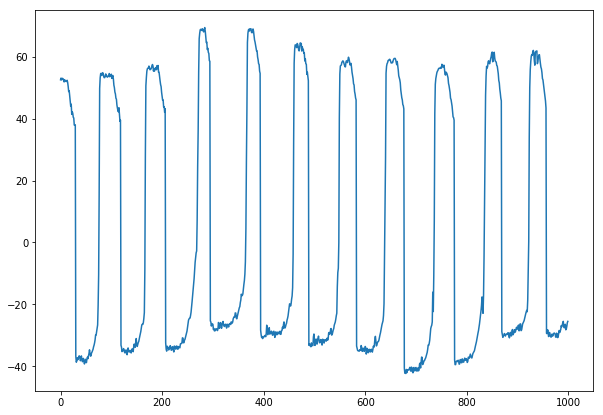

In [126]:
testPredict = model.predict(X_val)
testPredict = ((testPredict+1)/2)*196

trainPredict = model.predict(X[0:1000])
trainPredict = ((trainPredict+1)/2)*196
normY = ((Y_val+1)/2)*196

plt.figure(figsize=(10,7))
plt.plot(testPredict[0:1000,0])
plt.plot(normY[0:1000])
plt.show()

plt.figure(figsize=(10,7))
plt.plot(model.predict(X[0:1000])*100)
plt.plot(Y[0:1000]*100)
plt.show()

plt.figure(figsize=(10,7))
plt.plot(np.subtract(testPredict[0:1000,0],normY[0:1000]))
plt.show()

plt.figure(figsize=(10,7))
plt.plot(np.subtract(testPredict[0:1000,0],((Y[0:1000]+1)/2)*196))
plt.show()

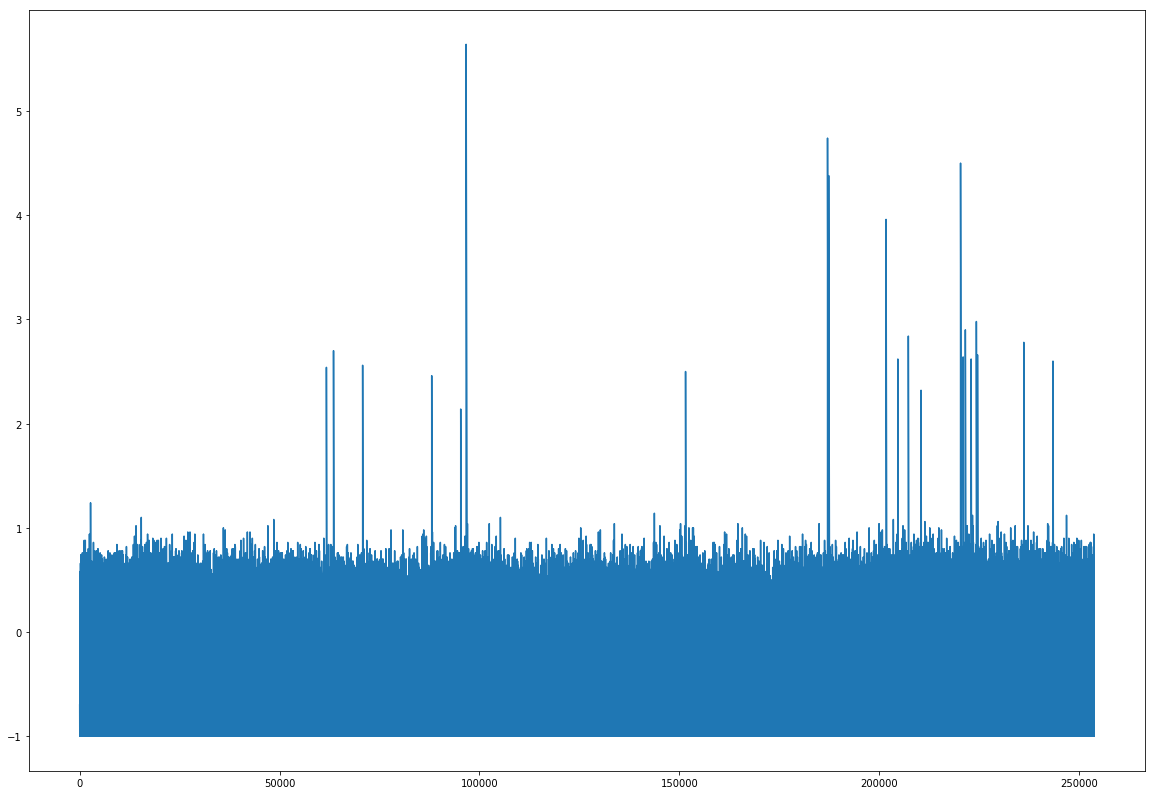

In [45]:
plt.figure(figsize=(20,14))
plt.plot(Y[:])
plt.show()

In [24]:
print(np.shape(X)[1])

260700


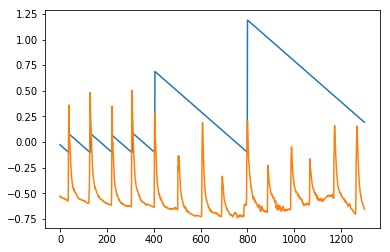

In [72]:
np.argmax(timing)
#plt.figure(figsize=(20,14))
plt.plot(timing[np.argmax(timing)-800:np.argmax(timing)+500]/10)

plt.plot(temp[np.argmax(timing)-800:np.argmax(timing)+500])
plt.show()